# Анализ средней активности пользователей в Москве и Санкт-Петербурге

- Автор: Арамян Элен
- Дата: 16.03.2025

## Цели и задачи проекта

**Цель:** проверить,  проводят ли пользователи из Санкт-Петербурга в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы

**Задачи:**
1) загрузить данные и познакомиться с ними

2) предобработать данные и нормализовать их

3) проверить гипотезы о средней активности пользователей двух городов - Москвы и Санкт-Петербурга

4) вывод и интерпретация результатов

## Описание данных

Таблица `/datasets/yandex_knigi_data.csv` c данными пользователей из Москвы и Санкт-Петербурга c их активностью. Содержит следующие столбцы:
+ Unnamed: 0 - порядковый номер строки
+ city - город (мск или питер)	
+ puid - уникальный идентификатор пользователя
+ hours - кол-во часов, проведенных в сервиса

## Содержимое проекта
1. Загрузка данных и знакомство с ними.
2. Проверка гипотезы в Python
3. Аналитическая записка

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
# Импортируем библиотеки
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
# Загружаем данные в датасет df
df = pd.read_csv('/datasets/yandex_knigi_data.csv')
display(df.head())

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


**Для корректного анализа данных и проверки гипотезы изучим датафрейм и предобработаем его**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


Пропуски отсутствуют. Изучим дубликаты

In [4]:
df.duplicated().sum()

0

In [5]:
df.duplicated('puid').sum()

244

In [6]:
df.duplicated(subset=['city', 'puid']).sum()

0

Полные дубли отсутствуют, однако есть дубли по идентификатору пользователя, но, если смотреть шире и захватить еще город, видим, что город у идентификаторов разный. Это может быть связано с тем, что один пользователь бывает в Мск и Спб или же одним аккаунтом пользуются из разных городов. Для дальнейшего проведения теста в целях сохранения независимости групп лучше удалить все дубли, тем более они составляют незначительные 5% от всех данных.

In [7]:
# Удалим все дубли по ид пользователя
df = df.drop_duplicates(subset='puid', keep=False)

In [8]:
df = df.drop('Unnamed: 0', axis = 1)
display(df)

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434
...,...,...,...
8778,Санкт-Петербург,1130000027468068,5.879444
8780,Санкт-Петербург,1130000030307246,45.069222
8781,Санкт-Петербург,1130000038726322,0.211944
8782,Санкт-Петербург,1130000047892100,4.311841


In [9]:
# Проверим аномальные значения
print(df['hours'].describe())

count    8296.000000
mean       10.963892
std        37.753906
min         0.000022
25%         0.057493
50%         0.884214
75%         5.944675
max       978.764775
Name: hours, dtype: float64


Видим выбросы, они могут повлиять на корректные выводы, поэтому избавимся от них с помощью процентилей (можно конечно взять и межквартильный размах, я даже попробовала так сделать, но процентили как будто в данном случае более щадящий способ)

In [10]:
# Установим пороги
lower_line = df['hours'].quantile(0.05)
upper_line = df['hours'].quantile(0.95)

In [11]:
filtered_df = df[(df['hours'] >= lower_line) & (df['hours'] <= upper_line)]

In [12]:
filtered_df['hours'].describe()

count    7466.000000
mean        4.996233
std         9.470833
min         0.002081
25%         0.083555
50%         0.884214
75%         4.863537
max        55.577836
Name: hours, dtype: float64

Далее сравним размеры групп и распределение часов активности в этих группах

In [13]:
filtered_df[filtered_df['city']== 'Санкт-Петербург']['puid'].count()

2082

In [14]:
filtered_df[filtered_df['city']== 'Москва']['puid'].count()

5384

Видим, что в Москве пользоваталей в 2.5 раза больше, чем в Питере. Рассмотрим, как распределены часы активности в обоих городах

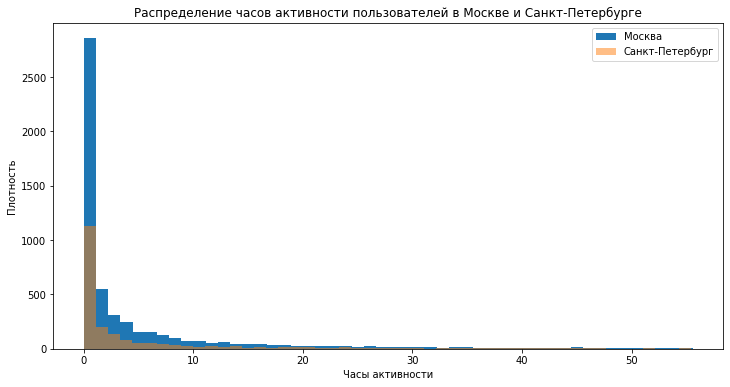

In [15]:
# Визуализируем распределения
moscow_hours = filtered_df[filtered_df['city'] == 'Москва']['hours']
petersburg_hours = filtered_df[filtered_df['city'] == 'Санкт-Петербург']['hours']

plt.figure(figsize=(12, 6))
plt.hist(moscow_hours, bins=50, label='Москва') 
plt.hist(petersburg_hours, bins=50, alpha=0.5, label='Санкт-Петербург')
plt.xlabel('Часы активности')
plt.legend()
plt.ylabel('Плотность')
plt.title('Распределение часов активности пользователей в Москве и Санкт-Петербурге')
plt.show()

На графике хорошо прослеживается, что распределения активностей примерно одинаковое (если брать в расчет что в спб в 2,5 раза меньше пользователей, то обе гистограммы будут +- одинаковые,  а то из-за разницы в кол-ве пользователей это не очень наглядно, можно это поправить, добавив density=True, но я не стала), а также видно, что обе гистограммы правосиметричного распределения

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [16]:
# Разделим датасет по городу
spb = filtered_df[filtered_df['city']== 'Санкт-Петербург']
msk = filtered_df[filtered_df['city']== 'Москва']

group_a = spb['hours']
group_b = msk['hours']

In [17]:
# Проверим средние значения
a_avg = group_a.mean()
b_avg= group_b.mean()

print('Средняя активность для выборки А = ', round(a_avg,2))
print('Средняя активность для выборки B = ', round(b_avg,2))
print('Разница между средней активностью выборок А и В:', round(a_avg- b_avg,3))

Средняя активность для выборки А =  5.23
Средняя активность для выборки B =  4.91
Разница между средней активностью выборок А и В: 0.32


Видим, что средняя активность двух выборок отличается незначительно. Однако делать выводы только на основе этого значения будет некорректно, тк нужно статистически это доказать

In [18]:
alpha = 0.05

results = st.ttest_ind(
        group_a,
        group_b,
        alternative='greater')

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Средняя активность пользователей в двух группах не различается.')

p-значение: 0.09502387264551075
Не получилось отвергнуть нулевую гипотезу. Средняя активность пользователей в двух группах не различается.


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости. 

- Результат теста, или p-value. 

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.


Аналитическая записка:
+ в процессе анализа информации данные были изучены и предобоработны: дубли удалены и датасет очищен от выбросов.
+ был проведен классический t-тест с уровнем статзначимости 0.05. Выбран именно классический тест, тк необходимо было сравнить среднюю активность двух групп, а также независимость наблюдений и нормальность выборочного среднего соблюдаются.
+ p-значение: 0.095
+ интерпретация: средняя активность пользователей в двух группах не различается
+ возможно, средняя активность в мск и питере не различается, тк это два крупнейших развитых города с одинаковой целевой аудиторией, у которых схожие интересы/образ жизни и тд. К тому же, миграция между мск и спб высокая, что в целом стирает границы и приводит к более "одинаковому" поведению в обоих городах